<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A convolutional autoencoder for spectroscopic data


Copyright (C) 2021 Vanessa Boehm (boehmvanessa@gmail.com)   
All Rights Reserved.    
You may use, distribute and modify this code under the   
terms of the GNU GENERAL PUBLIC LICENSE Version 3, 29 June 2007.    
You should have received a copy of the license with this file.    
If not, please write to the author or visit http://www.gnu.org/licenses/gpl-3.0-standalone.html.   


In [1]:
import torch
print('pytorch versions: ', torch.__version__)

if torch.cuda.is_available():
    print('GPUs available')
else:
    print('no GPUs found!!')


pytorch versions:  1.8.0
GPUs available


In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

In [3]:
### settings

RANDOM_SEED     = 12201215

DATA_DIM        = 1000
LATENT_DIM      = 10

NUM_CONV_BLOCKS = 4
FILTER_SIZES    = []
FILTER_NUMS     = []


In [4]:
### making sure everything is reproducible

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)

In [5]:
### convolutional layer output shape
def calculate_output_shape(L,padding,dilation,kernel_size,stride):
    shape = np.floor((L+2*padding-dilation*(kernel_size-1)-1)/stride+1)
    return shape

In [7]:
calculate_output_shape(1000,0,0,64,2)

500.0

In [ ]:
class ResBlock(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, stride=1, padding=0, dilation=0):

        assert(stride in [1,2])
        self.conv1      = torch.nn.Conv1d(input_channels, output_channels, kernel_size, stride=stride,padding=padding, dilation=dilation)
        self.bn1        = nn.BatchNorm1d(output_channels)
        self.relu       = nn.ReLU(inplace=True)
        self.conv2      = torch.nn.Conv1d(output_channels, output_channels, kernel_size, stride=stride, padding='valid')
        self.bn1        = nn.BatchNorm1d(output_channels)
        self.downsample = torch.nn.MaxPool1d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.stride     = stride

    def forward(self, x):
        
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if stride==2:
            identity = 

        out += identity
        out = self.relu(out)

        return out

In [3]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [4]:


dim             = fixed_num_bins

optimizer       = tf.keras.optimizers.Adam
batchsize       = 33
decay_steps     = 2300
dropouts_dec    = [0.]
dropouts_enc    = [0.]
latent_dim      = 10
lr_final        = 1.3e-05
lr_init         = 7e-4
out_features    = [1000,590]

def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True):
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)



def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}


def make_scheduler(length, initial_lr,factor=1.2):
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
    return scheduler
                             
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback  = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history   = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_types, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback],verbose=0)
    return history

def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

In [6]:
try:
    train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s_new.pkl'%label_),'rb'))
except:
    train_data = np.load(os.path.join(root_model_data,'train_%s_new.npy.npz'%label_))
    valid_data = np.load(os.path.join(root_model_data,'valid_%s_new.npy.npz'%label_))
    test_data = np.load(os.path.join(root_model_data,'test_%s_new.npy.npz'%label_))


    keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DEC', 'class', 'subclass','SN','MJD','plate','fiber', 'mean', 'std')

    train = {}
    for item, key in zip(train_data.files, keys):
        train[key] = train_data[item]


    valid = {}
    for item, key in zip(valid_data.files, keys):
        valid[key] =  valid_data[item]

    test = {}
    for item, key in zip(test_data.files, keys):
        test[key] = test_data[item]


    le = preprocessing.LabelEncoder()
    le.fit(train['subclass'])
    train['subclass'] = le.transform(train['subclass'])
    valid['subclass'] = le.transform(valid['subclass'])
    test['subclass']  = le.transform(test['subclass'])
    print(le.classes_, le.transform(le.classes_))        

    pickle.dump([train,valid,test,le],open(os.path.join(root_model_data,'combined_%s_new.pkl'%label_),'wb'))


data loaded from file
[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


In [7]:
Supernovas = pd.read_pickle('../forPub/Supernova_Sample.pkl')
df1 = pd.DataFrame()
df1['MJD']   = train['MJD']
df1['plate'] = train['plate']
df1['fiber'] = train['fiber']
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))
df1 = pd.DataFrame()
df1['MJD']   = valid['MJD']
df1['plate'] = valid['plate']
df1['fiber'] = valid['fiber']
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))
df1 = pd.DataFrame()
df1['MJD']   = test['MJD']
df1['plate'] = test['plate']
df1['fiber'] = test['fiber']
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))

7
3
3


In [8]:
input        = Input(shape=(dim,1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))
input_type   = Input(shape=(1,1))
input_params = Input(shape=(1,1))

if cond_on=='type':
    z = input_type
if cond_on=='redshift':
    z = input_params

n_layers   = 3
latent_dim = latent_dim

x = input
for ii in range(n_layers-1):
    if ii>0:
        x = Dropout(dropouts_enc[ii-1])(x)
    x = dense_block(x,out_features[ii])
    
x = dense_block(x,latent_dim,non_lin=False)
x = Reshape((latent_dim,1))(x)

for ii in range(n_layers-1):
    if conditional:
        x = dense_cond_block(x,z,out_features[-1-ii])
    else:
        x = dense_block(x,out_features[-1-ii])
    if ii ==0:
        pass
    else:
        x = Dropout(dropouts_dec[ii-1])(x)
if conditional:
    x = dense_cond_block(x,z,dim, non_lin=False)
else:
    x = dense_block(x,dim, non_lin=False)


learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
lr_init,
decay_steps,
lr_final,
power=0.5, cycle=True)

optim = optimizer

lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
lstm_ae.compile(optimizer=optim(learning_rate=learning_rate_fn), my_loss=lossFunction, metrics=[],run_eagerly=False)
lstm_ae.summary()

Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1000)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1000)         1001000     flatten[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1000)         0           dense[0][0]                      
_______________________________________________________________________________________

In [9]:
path = os.path.join(root_models,'full_ae_model_%s_run%s_new'%(label_2,RUN))

lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS)

res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)

print('final validation loss:', recon_error)
print('final validation reconstruction error:', np.sqrt(recon_error))


lstm_ae.save(path)

Epoch 1/40
6348/6348 [==============================] - 10s 2ms/step - training_loss: 4.8945
Epoch 2/40
6348/6348 [==============================] - 10s 2ms/step - training_loss: 1.7872
Epoch 3/40
6348/6348 [==============================] - 10s 2ms/step - training_loss: 1.5283
Epoch 4/40
6348/6348 [==============================] - 10s 2ms/step - training_loss: 1.4534
Epoch 5/40
6348/6348 [==============================] - 10s 2ms/step - training_loss: 1.3854
Epoch 6/40
6348/6348 [==============================] - 10s 2ms/step - training_loss: 1.3422
Epoch 7/40
6348/6348 [==============================] - 10s 2ms/step - training_loss: 1.3230
Epoch 8/40
6348/6348 [==============================] - 10s 2ms/step - training_loss: 1.3126
Epoch 9/40
6348/6348 [==============================] - 10s 2ms/step - training_loss: 1.3050
Epoch 10/40
6348/6348 [==============================] - 10s 2ms/step - training_loss: 1.2892
Epoch 11/40
6348/6348 [==============================] - 10s 2ms/step

In [10]:
for label in np.arange(8):
    print(le.inverse_transform([label]))
    index = np.where(valid['subclass']==label)[0]
    res_valid = lstm_ae.predict((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]))
    print('validation: ', custom_metric((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]),res_valid))
    index = np.where(train['subclass']==label)[0]
    lng   = min(len(res_valid),len(index))
    res_train = lstm_ae.predict((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]))
    print('training: ', custom_metric((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]),res_train))

[b'']
validation:  1.1830573712524284
training:  1.1795505723309219
[b'AGN']
validation:  1.3154684857037937
training:  1.3133115385941567
[b'AGN BROADLINE']
validation:  1.6542490372179086
training:  1.6160045730565693
[b'BROADLINE']
validation:  1.4430959783798165
training:  1.418389640246852
[b'STARBURST']
validation:  1.4068126406499695
training:  1.3780547543329134
[b'STARBURST BROADLINE']
validation:  2.821784272341317
training:  1.8016903922157148
[b'STARFORMING']
validation:  1.2549337993464993
training:  1.2519760944790652
[b'STARFORMING BROADLINE']
validation:  1.3927239045893165
training:  1.4150957102129469


In [11]:
# def bootstrap(train_data, batch_size):
#     index   = np.arange(len(train['spec']))
#     metrics = []
#     for ii in range(1000):
#         sample    = np.random.choice(index, size=batch_size, replace=False, p=None)
#         res_train = lstm_ae.predict((train['spec'][sample],train['mask'][sample],train['noise'][sample], train['subclass'][sample],train['z'][sample]))
#         metric    = custom_metric((train['spec'][sample],train['mask'][sample],train_data['noise'][sample], train['subclass'][sample],train['z'][sample]),res_train)
#         metrics.append(metric)
#     return np.mean(metrics), np.std(metrics)

In [12]:
#bootstrap(train, batch_size=len(valid['spec']))

In [13]:
### concatenate and split input
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [14]:
def extract_layers_base(main_model, starting_layer_ix, ending_layer_ix):
    layers=[]
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        layers.append(curr_layer)
    return layers

In [15]:
encoder = extract_layers(lstm_ae,0,13)
encoder.build((None,fixed_num_bins,1))
encoder.summary()

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aaba91a7c10>
1 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad9ca38af0>
2 <tensorflow.python.keras.layers.core.Dense object at 0x2aad9ca38c40>
3 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aad9ca598b0>
4 <tensorflow.python.keras.layers.core.Reshape object at 0x2aad9ca59b20>
5 <tensorflow.python.keras.layers.core.Dropout object at 0x2aad9ca59670>
6 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad9caafeb0>
7 <tensorflow.python.keras.layers.core.Dense object at 0x2aad9ca89dc0>
8 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aad9ccbef70>
9 <tensorflow.python.keras.layers.core.Reshape object at 0x2aad9ccd1d00>
10 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad9ca38640>
11 <tensorflow.python.keras.layers.core.Dense object at 0x2aad9ccd1970>
12 <tensorflow.python.keras.layers.core.Reshape object at 0x2aad9cce0700>
Model: "

In [16]:
if conditional:
    decoder = extract_layers_base(lstm_ae,13,25)
    input      = Input(shape=(latent_dim,1))
    input_type = Input(shape=(1,1))
    print(decoder[0])
    x          = decoder[0]((input,input_type))
    for ii in range(1,len(decoder)):
        try:
            x = decoder[ii](x)
        except:
            x = decoder[ii]((x, input_type))
    decoder = Model((input,input_type),x)
else:
    decoder = extract_layers(lstm_ae,13,25)
    decoder.build((None,latent_dim,1))

13 <tensorflow.python.keras.layers.core.Reshape object at 0x2aad9ccd1820>
14 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad9cce06a0>
15 <tensorflow.python.keras.layers.core.Dense object at 0x2aad9cce7070>
16 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aad9cceffa0>
17 <tensorflow.python.keras.layers.core.Reshape object at 0x2aad9cceff40>
18 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad9ccefcd0>
19 <tensorflow.python.keras.layers.core.Dense object at 0x2aad9ccf7d60>
20 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aad9cd01ca0>
21 <tensorflow.python.keras.layers.core.Reshape object at 0x2aad9cd01df0>
22 <tensorflow.python.keras.layers.core.Dropout object at 0x2aad9cd07f70>
23 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad9cce03a0>
24 <tensorflow.python.keras.layers.core.Dense object at 0x2aad9cd0ed30>


In [17]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 590)               6490      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 590)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 590, 1)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 590)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)             

In [18]:
encoded_valid = encoder.predict(valid['spec'])
encoded_train = encoder.predict(train['spec'])
encoded_test  = encoder.predict(test['spec'])

In [19]:
if conditional:
    decoded_train  = decoder.predict((np.expand_dims(encoded_train,-1), np.expand_dims(train['subclass'],-1)))
    decoded_test   = decoder.predict((np.expand_dims(encoded_test,-1), np.expand_dims(test['subclass'],-1)))
    decoded_valid  = decoder.predict((np.expand_dims(encoded_valid,-1), np.expand_dims(valid['subclass'],-1)))
else:
    decoded_train  = decoder.predict(encoded_train)
    decoded_test   = decoder.predict(encoded_test)
    decoded_valid  = decoder.predict(encoded_valid)   

In [20]:
path = os.path.join(root_models,'encoder_%s_run%s_new'%(label_2, RUN))
encoder.save(path)
path = os.path.join(root_models,'decoder_%s_run%s_new'%(label_2, RUN))
decoder.save(path)
print(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_run1_new/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_run1_new/assets
/global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_run1_new


In [21]:
path = os.path.join(root_models,'encoder_%s_run%s_new'%(label_2, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_run%s_new'%(label_2, RUN))
decoder = tf.keras.models.load_model(path)

In [22]:
encoded_valid = np.squeeze(encoded_valid)
encoded_train = np.squeeze(encoded_train)
encoded_test  = np.squeeze(encoded_test)

In [23]:
np.save(os.path.join(root_encoded,'encoded_%s_RUN%s_new.npy'%(label_2,RUN)),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s_new.npy'%(label_2,RUN)), allow_pickle=True)

In [24]:
np.save(os.path.join(root_decoded,'decoded_%s_RUN%s_new.npy'%(label_2,RUN)),[decoded_train,decoded_valid, decoded_test, train['mean'], train['std']])

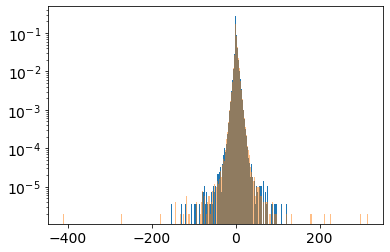

In [25]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

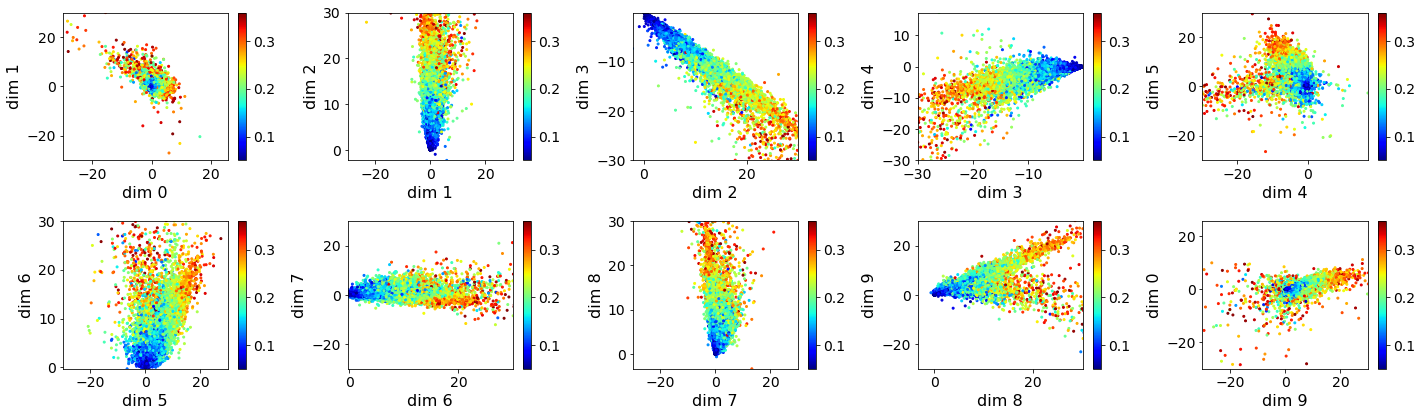

In [26]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['z'], cmap='jet',s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_valid_redshift_AE1.pdf'), bbox_inches='tight')
plt.show()


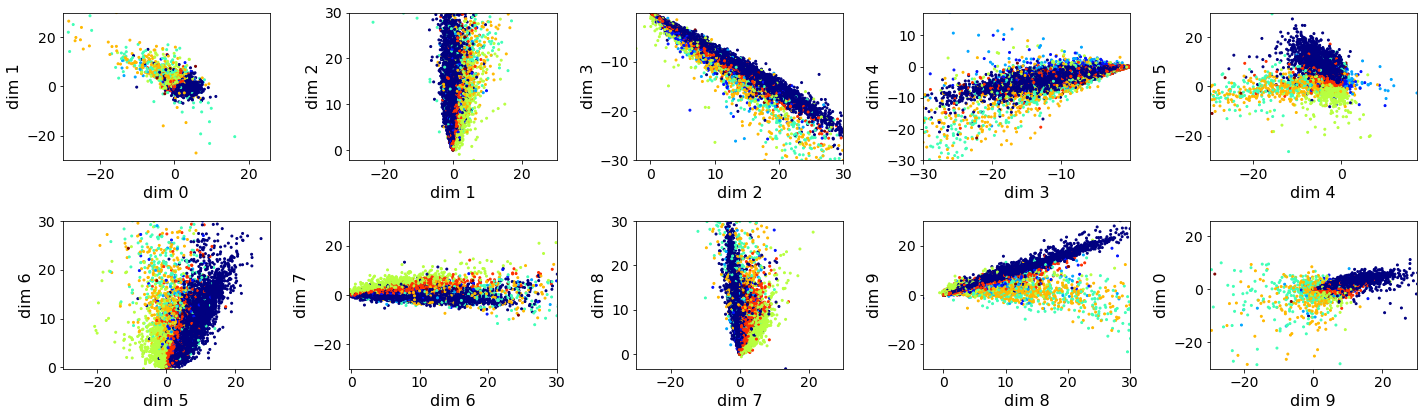

In [27]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['subclass'], cmap='jet', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    #plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_valid_subclass_AE1.pdf'), bbox_inches='tight')
plt.show()


In [28]:
import seaborn as sns

In [29]:
df1 = pd.DataFrame()
df1['subclass']=train['subclass']

In [30]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax=7)
rgba = cmap(norm(np.arange(8)))

In [31]:
new_label = np.asarray([40789,2098,214,205,3658,70,2225,183])
old_label = np.asarray([43168,423,105,563,3642,15,1486,40])

new_counts = new_label/old_label*(np.unique(df1['subclass'], return_counts=True)[1])

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


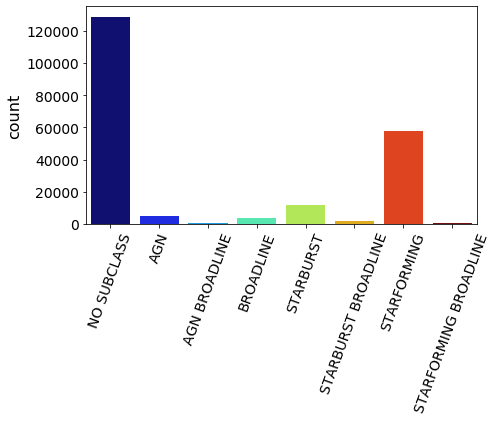

In [32]:
color_map = dict(zip(np.arange(8), rgba))
plt.figure(figsize=(7, 4))
p=sns.countplot(df1['subclass'],palette=color_map)
#p=sns.barplot(np.arange(8),new_counts,palette=color_map,alpha=1.0)
# plt.title('Total Athletes contribution in summer olympics over time')
labels =[]
for ii, x in enumerate(le.inverse_transform(np.arange(8))):
    if ii >0:
        labels.append(x.decode('utf-8'))
    else:
        labels.append('NO SUBCLASS') 
plt.xticks(np.arange(8), labels ,rotation=70)
plt.xlabel('')
# plt.ylabel('No. of Athlete')
plt.show()

In [34]:
noise            = np.ma.array(np.squeeze(valid['noise']),mask=~np.squeeze(valid['mask'].astype('bool')))
#noise_recon      = np.ma.array(np.tile(loss[0]/np.mean(valid['mask'],axis=0), (len(valid['noise']))).T,mask=~np.squeeze(valid['mask'].astype('bool')))
recon_error      = np.ma.mean(np.ma.array(np.squeeze(valid['spec'])-decoded_valid,mask=~np.squeeze(valid['mask'].astype('bool')))**2*(noise),axis=1)

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, '$\\chi^2$ distribution')

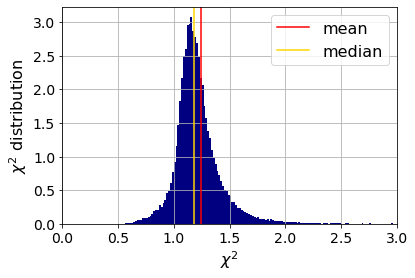

In [35]:
plt.hist(recon_error,bins=300,density=True,range=(0,5),color='navy')
plt.axvline(recon_error.mean(),color='red',label='mean')
plt.axvline(np.median(recon_error),color='gold',label='median')
plt.xlim(0,3)
plt.grid()
plt.legend()
plt.xlabel(r'$\chi^2$')
plt.ylabel(r'$\chi^2$ distribution')

Text(0.5, 0, '$\\chi^2$')

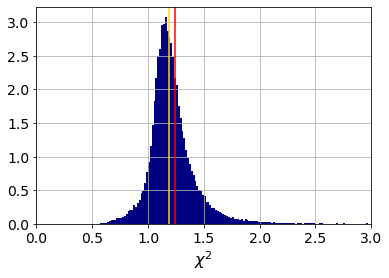

In [36]:
plt.hist(recon_error,bins=300,density=True,range=(0,5),color='navy')
plt.axvline(recon_error.mean(),color='red',label='mean')
plt.axvline(np.median(recon_error),color='gold',label='median')
plt.xlim(0,3)
plt.grid()
plt.xlabel(r'$\chi^2$')

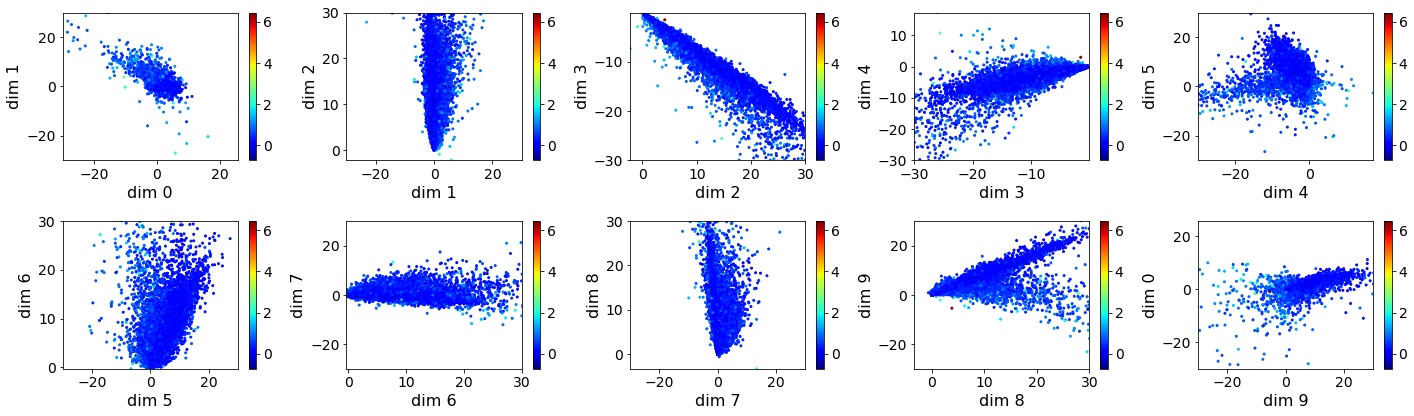

In [37]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=np.log(recon_error), cmap='jet', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_noise_AE1.pdf'), bbox_inches='tight')
plt.show()

In [38]:
wlmin, wlmax    = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

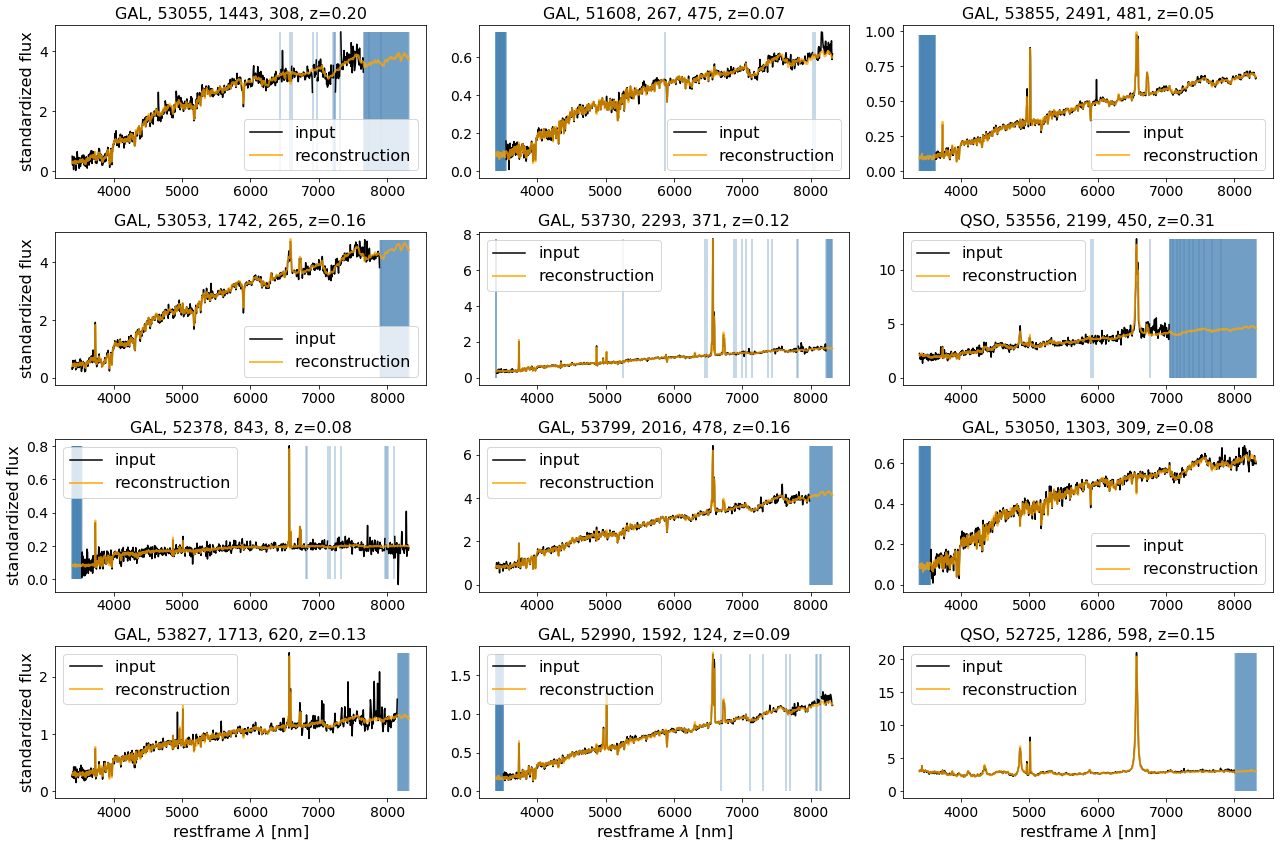

In [49]:
masked={}
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))
masked['test'] = np.ma.array(np.squeeze(test['spec']),mask=~np.squeeze(test['mask'].astype('bool')))
classes = {2:'GAL', 1:'QSO', 0:'STAR'}
fi, ax = plt.subplots(4,3,figsize=(18,12))
ax     = ax.flatten()
for ii in range(12):
    ind = (test['subclass']==(ii%8))
    ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ii]], test['MJD'][ind][ii],test['plate'][ind][ii],test['fiber'][ind][ii],test['z'][ind][ii]))
    ax[ii].plot(new_wl[1:],masked['test'][ind][ii],label='input', color='black')
    ax[ii].vlines(x=new_wl[1:][np.squeeze(~test['mask'][ind][ii].astype(bool))], ymin=0,ymax=max(test['spec'][ind][ii]), color='steelblue',alpha=0.4)
    ax[ii].plot(new_wl[1:],decoded_test[ind][ii], label='reconstruction',ls='-', color='orange', lw=2, alpha=0.75)

    ax[ii].legend()
    if ii in [9,10,11]:
        ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
    if ii%3==0:
        ax[ii].set_ylabel(r'standardized flux')       
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'reconstructions_test_AE1.pdf'), bbox_inches='tight')
plt.show()

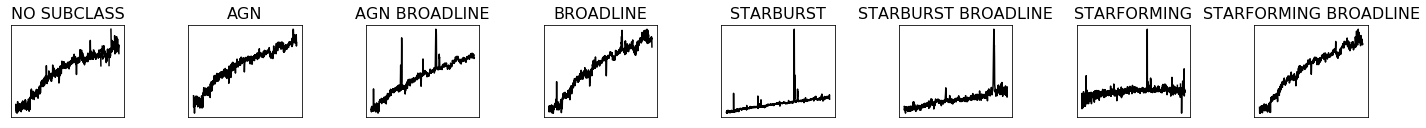

In [50]:
masked={}
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))
masked['test'] = np.ma.array(np.squeeze(test['spec']),mask=~np.squeeze(test['mask'].astype('bool')))
classes = {2:'GAL', 1:'QSO', 0:'STAR'}
fi, ax = plt.subplots(1,8,figsize=(20,2))
ax     = ax.flatten()
for ii in range(8):
    ind = (test['subclass']==(ii%7))
    ax[ii].set_title(labels[ii])
    ax[ii].plot(new_wl[1:],masked['test'][ind][ii],label='input', color='black')
    #ax[ii].vlines(x=new_wl[1:][np.squeeze(~test['mask'][ind][ii].astype(bool))], ymin=0,ymax=max(test['spec'][ind][ii]), color='steelblue',alpha=0.4)
    #ax[ii].plot(new_wl[1:],decoded_test[ind][ii], label='reconstruction',ls='-', color='orange', lw=2, alpha=0.75)

    #ax[ii].legend()
    # if ii in [9,10,11]:
    #     ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
    # if ii%3==0:
    #     ax[ii].set_ylabel(r'standardized flux')
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
plt.tight_layout()
#plt.savefig(os.path.join(plotpath,'reconstructions_test_AE1.pdf'), bbox_inches='tight')
plt.show()

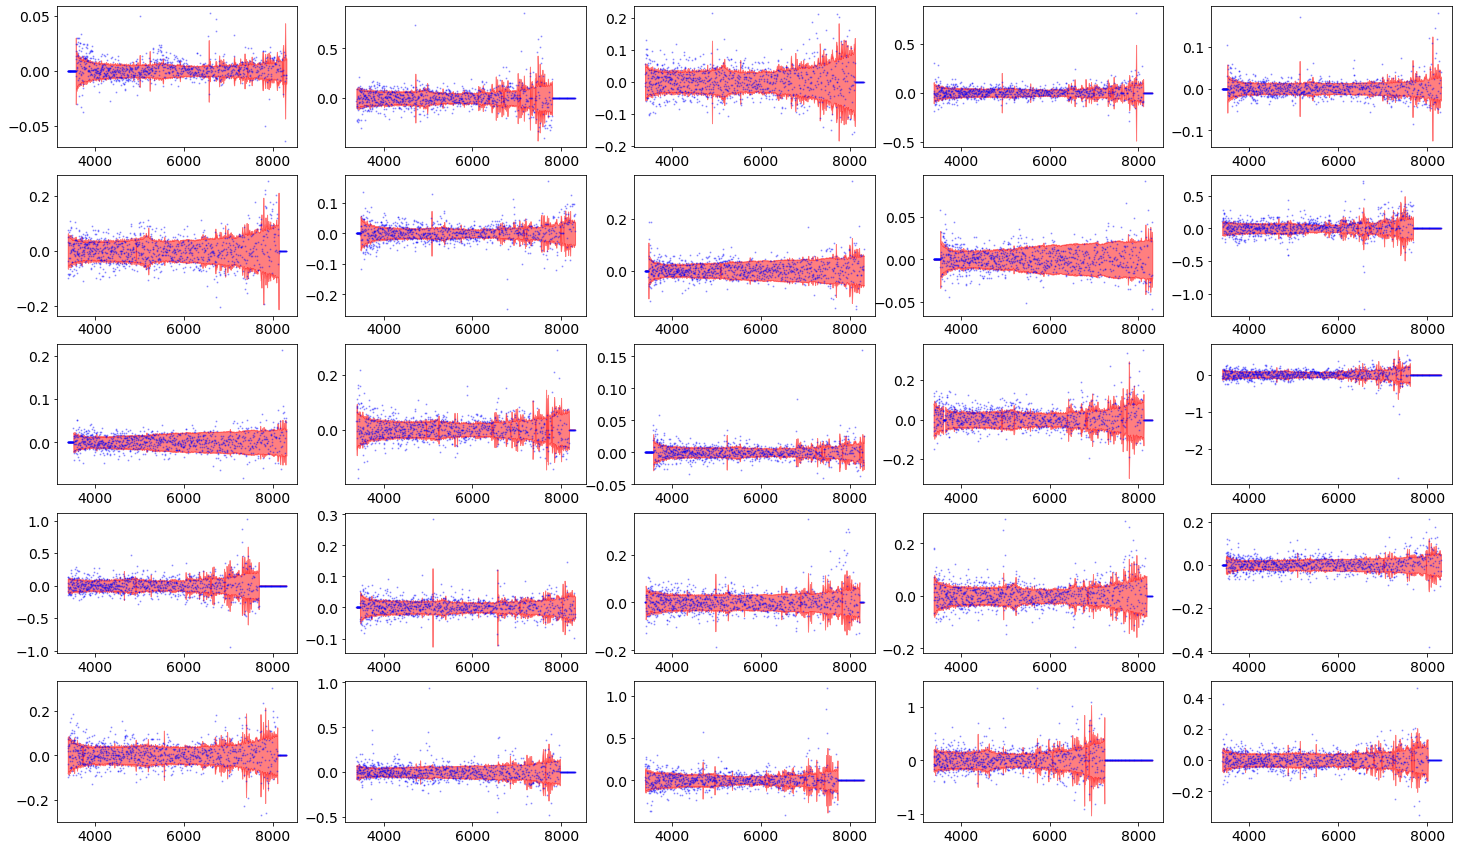

In [51]:
noise = np.zeros(valid['noise'].shape)
ind   = np.where(valid['noise']!=0)
noise[ind] = np.sqrt(1./np.squeeze(valid['noise'][ind]))

noise = np.squeeze(noise)


fig, ax = plt.subplots(5,5, figsize=(25,15))
ax = ax.flatten()
for nn, ii in enumerate(np.arange(25)):
    ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec'])[ii]-decoded_valid[ii])*np.squeeze(valid['mask'][ii]),color='blue', alpha=0.3,ls='',marker='o', markersize=1)
    ax[nn].fill_between(new_wl[:-1], -noise[ii], noise[ii], alpha=0.5, color='red')               
plt.show()

In [52]:
### Look at reconstruction ability as function of wavelength

In [53]:
def loss_by_wl(y_true, y_pred):
    loss           = (y_true[0]-y_pred)**2*y_true[2]*y_true[1]
    valid_loss     = np.mean(loss,axis=0)
    std_valid_loss = np.std(loss,axis=0)
    return valid_loss, std_valid_loss

In [54]:
loss = loss_by_wl((valid['spec'],valid['mask'],valid['noise']),np.expand_dims(decoded_valid,-1))

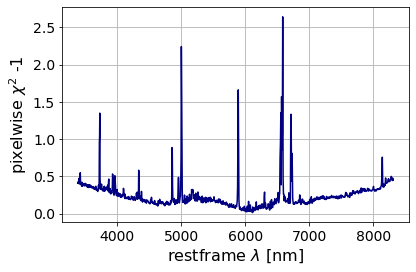

In [55]:
plt.plot(new_wl[:-1],loss[0]/np.mean(valid['mask'],axis=0)-1,color='navy')
plt.xlabel(r'restframe $\lambda$ [nm]')
plt.ylabel('pixelwise $\chi^2$ -1')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'mean_reconstruction_error_AE1.pdf'), bbox_inches='tight')

In [46]:
Supernovas = pd.read_pickle('../forPub/Supernova_Sample.pkl')

In [ ]:
seed=154
np.random.seed(seed)
sample = np.random.randint(0,len(test['spec']),12)

In [ ]:
df1 = pd.DataFrame()
df1['MJD']   = test['MJD']
df1['plate'] = test['plate']
df1['fiber'] = test['fiber']
df1['index'] = np.arange(len(test['fiber']))
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])

In [ ]:
sns

In [ ]:
masked={}
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))
masked['test'] = np.ma.array(np.squeeze(test['spec']),mask=~np.squeeze(test['mask'].astype('bool')))
classes = {2:'GAL', 1:'QSO', 0:'STAR'}
fi, ax = plt.subplots(1,3,figsize=(18,3))
ax     = ax.flatten()
for ii in range(3):
    ind = sns['index']
    #ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ii]], test['MJD'][ind][ii],test['plate'][ind][ii],test['fiber'][ind][ii],test['z'][ind][ii]))
    ax[ii].plot(new_wl[1:],masked['test'][ind][ii],color='black')
    ax[ii].vlines(x=new_wl[1:][np.squeeze(~test['mask'][ind][ii].astype(bool))], ymin=0,ymax=max(test['spec'][ind][ii]), color='steelblue')
    #ax[ii].plot(new_wl[1:],decoded_test[ind][ii], label='reconstruction',ls='-', color='orange', lw=2, alpha=0.75)

    #ax[ii].legend()
    #if ii in [11,12]:
    #ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
    #if ii%2==0:
    #ax[ii].set_ylabel(r'standardized flux')
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
#plt.xticks([])
plt.tight_layout()
#plt.savefig(os.path.join(plotpath,'reconstructions_test_AE1.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
51999, 362, 26

In [ ]:
np.where((valid['MJD']==51999)*(valid['plate']==26)*(valid['fiber']==362))

In [ ]:
import seaborn as sns

In [ ]:
penguins = sns.load_dataset("penguins")


In [ ]:
penguins.rename(columns={'bill_length_mm':'dim 1','bill_depth_mm':'dim 2'},inplace=True)

In [ ]:
penguins

In [5]:
data1 = penguins[(penguins['dim 1']>55.6)*(penguins['dim 2']<18)]
data2 = penguins[(penguins['dim 1']<35)*(penguins['dim 2']<16)]
data3 = penguins[(penguins['dim 1']<38)*(penguins['dim 2']>21)]
data4 = penguins[(penguins['dim 1']<50)*(penguins['dim 2']>21.2)]

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, u

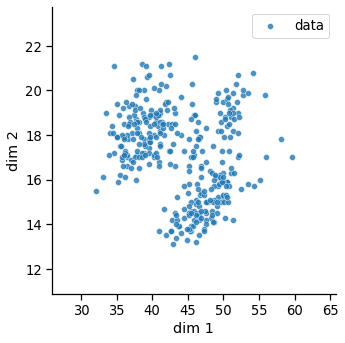

In [17]:

with sns.plotting_context('notebook',font_scale=1.2):
    sns.displot(penguins, x="dim 1", y="dim 2", kind="kde", alpha=0)
    sns.scatterplot(data=penguins, x="dim 1", y="dim 2", alpha=0.8 , label='data')
    # sns.displot(penguins, x="dim 1", y="dim 2", kind="kde", fontsize=12)
    # sns.scatterplot(data=data1, x="dim 1", y="dim 2")
    # sns.scatterplot(data=data2, x="dim 1", y="dim 2")
    # sns.scatterplot(data=data4, x="dim 1", y="dim 2")
    # sns.scatterplot(data=data3, x="dim 1", y="dim 2")

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'fontsize'
  cset = contour_func(


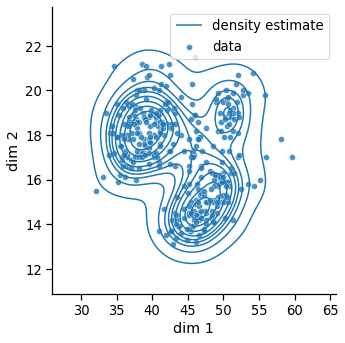

In [11]:
with sns.plotting_context('notebook',font_scale=1.2):
    sns.displot(penguins, x="dim 1", y="dim 2", kind="kde", fontsize=12, label='density estimate')
    sns.scatterplot(data=penguins, x="dim 1", y="dim 2", alpha=0.8 , label='data')
    # 
    # sns.scatterplot(data=data1, x="dim 1", y="dim 2", color='orangered', label='outlier')
    # sns.scatterplot(data=data2, x="dim 1", y="dim 2", color='orangered')
    # sns.scatterplot(data=data4, x="dim 1", y="dim 2", color='orangered')
    # sns.scatterplot(data=data3, x="dim 1", y="dim 2", color='orangered')

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'fontsize'
  cset = contour_func(


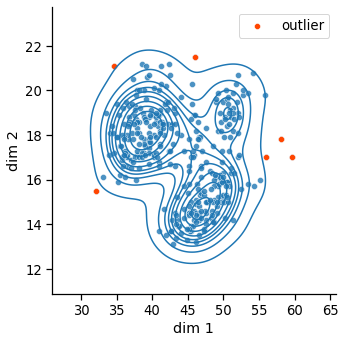

In [15]:
with sns.plotting_context('notebook',font_scale=1.2):
    sns.displot(penguins, x="dim 1", y="dim 2", kind="kde", fontsize=12)
    sns.scatterplot(data=penguins, x="dim 1", y="dim 2", alpha=0.8 ) 
    sns.scatterplot(data=data1, x="dim 1", y="dim 2", color='orangered', label='outlier')
    sns.scatterplot(data=data2, x="dim 1", y="dim 2", color='orangered')
    sns.scatterplot(data=data4, x="dim 1", y="dim 2", color='orangered')
    sns.scatterplot(data=data3, x="dim 1", y="dim 2", color='orangered')

In [14]:
import matplotlib.animation as animation